# Phase Estimation Algorithm

**Goal:**  
Estimate the phase $\theta$ of an eigenvalue  
\begin{equation*}
\lambda = e^{2\pi i \theta}
\end{equation*}
for a given unitary $U$ and known eigenvector $\ket\varphi$, using the standard Quantum Phase Estimation (QPE) algorithm.


**Key parameters**

- $m$: number of control (phase-register) qubits → sets the resolution $1/2^m$.  
- $\ket\varphi$: known eigenvector of $U$.  
- Measured register outcome $k$ → $\hat\theta = k/2^m$.


More informations can be found in the Qiskit tutorial [Qiskit Phase Estimation](https://learning.quantum.ibm.com/course/fundamentals-of-quantum-algorithms/phase-estimation-and-factoring)


In [1]:
import numpy as np
import pandas as pd
from math import pi
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit,QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import (CCXGate, CXGate, CZGate,
                                    Initialize, PhaseGate, QFT, UnitaryGate)
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram


### Unitary-test definitions :

In [2]:
def U_gate_phase(theta):
    """Single-qubit U gate: diag(1, e^{2πiθ})"""
    return PhaseGate(2 * pi * theta, label=f"U(θ={theta:.3f})")


# List of unitaries with known eigenvectors and eigenphases
unitary_tests = [
    {
        "name": "Phase(θ=0.3)",
        "U": U_gate_phase(0.3),
        "num_qubits": 1,
        "theta": 0.3,
        "eigenvector": [0, 1]  # |1⟩
    },
    {
        "name": "Z gate",
        "U": UnitaryGate([[1, 0], [0, -1]], label="Z"),
        "num_qubits": 1,
        "theta": 0.5, 
        "eigenvector": [0, 1]  # |1⟩
    },
    {
        "name": "CNOT (control=0, target=1)",
        "U": CXGate(),
        "num_qubits": 2,
        "theta": 0.0,  # |+0⟩ is a 1-eigenvector
        "eigenvector": [1/np.sqrt(2), 0, 1/np.sqrt(2), 0]  # |+0⟩ in 2-qubit basis
    },
    {
        "name": "CZ gate",
        "U": CZGate(),
        "num_qubits": 2,
        "theta": 0.5,  #
        "eigenvector": [0, 0, 0, 1]  # |11⟩
    },
    {
        "name": "Custom diag(θ=0.7) on |11⟩",
        "U": UnitaryGate(np.diag([1, 1, 1, np.exp(2j * pi * 0.7)]), label="Diag"),
        "num_qubits": 2,
        "theta": 0.7,
        "eigenvector": [0, 0, 0, 1]  # |11⟩
    }
]

In [3]:
# Choose the test
test = unitary_tests[4]

U_gate = test["U"]
theta = test["theta"]
vec = test["eigenvector"]
num_qubits = test["num_qubits"]

print(f"Testing unitary: {test['name']}")
print(f"theta = {theta} and expected eigenvalue: e^(2πi * {theta})")


Testing unitary: Custom diag(θ=0.7) on |11⟩
theta = 0.7 and expected eigenvalue: e^(2πi * 0.7)


## Phase Estimation Algorithm

![Phase Estimation Circuit](phase-estimation-procedure.avif)

In [4]:
def apply_phase_estimation(qc, control_qubits, target_qubits, U_gate):

    # Step 1: Hadamards on control qubits
    for j, ctrl in enumerate(control_qubits):
        qc.h(ctrl)

        # Apply controlled-U^{2^j}
        U_power = U_gate.power(2 ** j)
        CU = U_power.control(1)
        qc.append(CU, [ctrl] + target_qubits)


    qc.barrier()

    # Step 2: Inverse QFT on control qubits
    iqft = QFT(len(control_qubits), inverse=True, do_swaps=True)
    qc.compose(iqft, qubits=control_qubits, inplace=True)

    qc.barrier()

    # Step 3: Measure control qubits into classical bits (assumes they are mapped 1:1)
    qc.measure(control_qubits, qc.clbits[:len(control_qubits)])

### Initialize the circuit

In [5]:
# Number of control qubits
m = 5

# Create the quantum circuit
control = QuantumRegister(m, name="Control")
eigenvector = QuantumRegister(num_qubits, name="EV")
output = ClassicalRegister(m, name="Classical")
qc = QuantumCircuit(control, eigenvector, output)

# Prepare the eigenvector
init = Initialize(vec)
qc.append(init, eigenvector[:num_qubits])

### Run and analyse the results

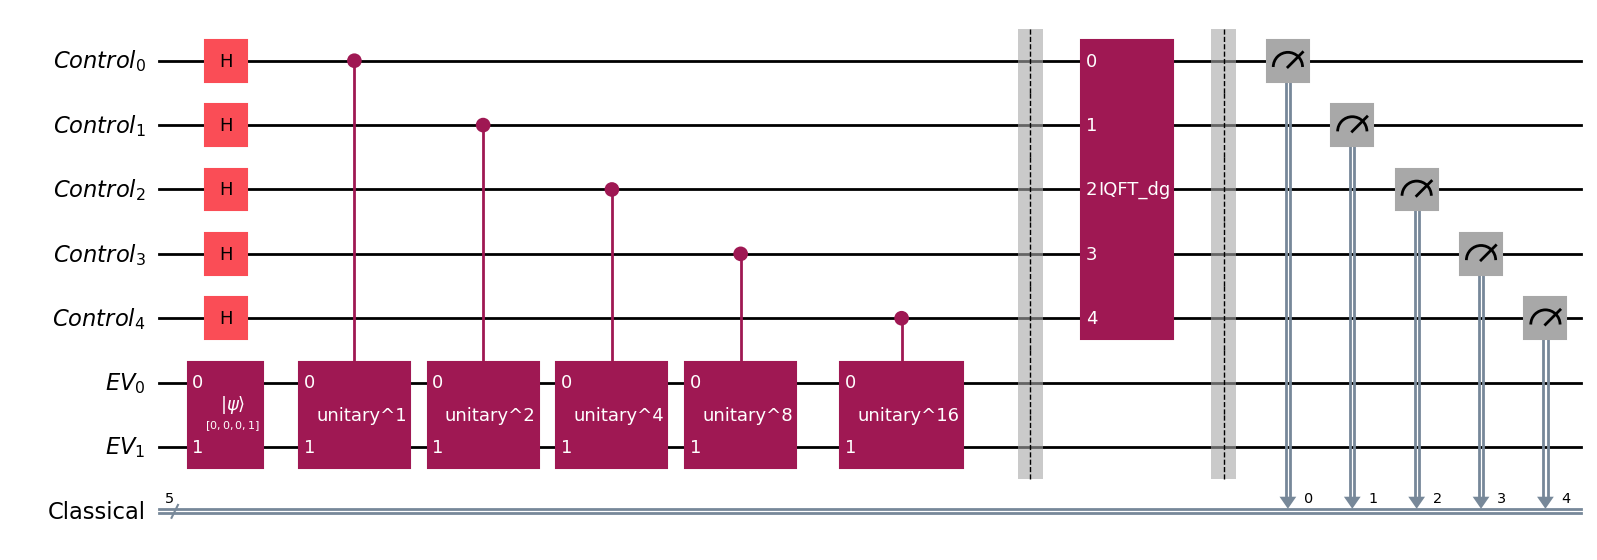

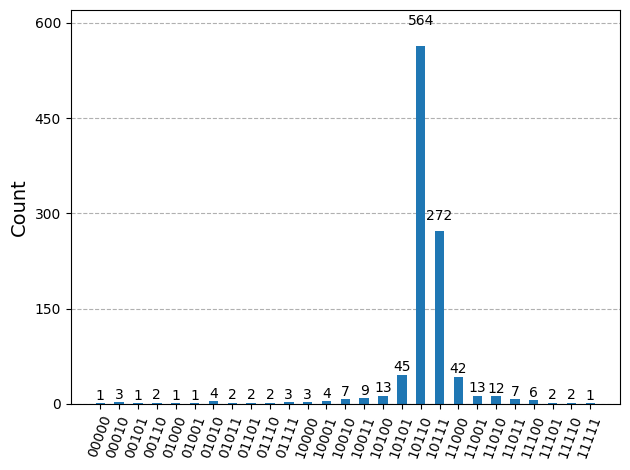

In [6]:
# Apply the algorithm
apply_phase_estimation(qc, list(control), list(eigenvector), U_gate)

# Display the quantum circuit
display(qc.draw('mpl'))

# Simulate the circuit
qc_transpiled = transpile(qc, backend=AerSimulator())
result = AerSimulator().run(qc_transpiled).result()
statistics = result.get_counts()

# Plot the results
display(plot_histogram(statistics))

In [7]:
# Extract most probable binary result
most_probable_bin = max(statistics, key=statistics.get)
most_probable = int(most_probable_bin, 2)

# Estimate theta
estimated_theta = most_probable / 2**m

# Print results
print(f"Most probable output (binary): {most_probable_bin}")
print(f"Most probable output (decimal): {most_probable}")
print(f"Estimated θ: {estimated_theta}")
print(f"True θ: {test['theta']}")


Most probable output (binary): 10110
Most probable output (decimal): 22
Estimated θ: 0.6875
True θ: 0.7


To improve accuracy, we fit a Gaussian curve to the histogram and use its peak location for our phase estimate

In [8]:
def estimate_from_hist(counts: dict, m: int):
    # 1) Raw-peak estimate
    peak_bin = max(counts, key=counts.get)
    raw_theta = int(peak_bin, 2) / 2**m

    # 2) Prepare for Gaussian fit
    x = np.array([int(k, 2) for k in counts])
    y = np.array([counts[k] for k in counts])

    # If fewer than 3 bins, skip fitting
    if x.size < 5:
        return raw_theta, raw_theta

    # Window around the peak
    mu0 = x[np.argmax(y)]
    mask = np.abs(x - mu0) <= 5
    if mask.sum() < 5:
        mask = np.ones_like(mask, dtype=bool)

    x_fit = x[mask]
    y_fit = y[mask]

    # Try Gaussian fit
    try:
        def gauss(xx, A, mu, s):
            return A * np.exp(-(xx - mu)**2 / (2 * s**2))

        p0 = [y_fit.max(), mu0, 1.0]
        params, _ = curve_fit(gauss, x_fit, y_fit, p0=p0)
        fit_theta = params[1] / 2**m
    except Exception:
        fit_theta = raw_theta

    return raw_theta, fit_theta


Raw-peak estimate of θ:      0.687500
Gaussian-fit estimate of θ:  0.696000
Original test θ:             0.700000


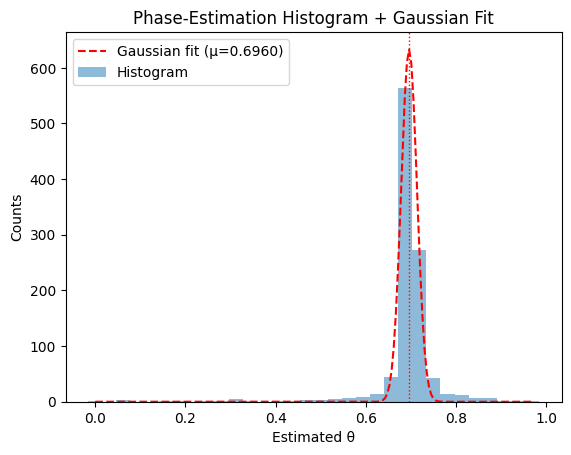

In [9]:
raw, fit = estimate_from_hist(statistics, m)

print(f"Raw-peak estimate of θ:      {raw:.6f}")
print(f"Gaussian-fit estimate of θ:  {fit:.6f}")
print(f"Original test θ:             {test['theta']:.6f}")

# Prepare data for plotting
x_int   = np.array([int(k, 2) for k in statistics])      # 0, 1, 2, …
y       = np.array([statistics[k] for k in statistics]) # counts
x_theta = x_int / 2**m                                    # convert bins → θ

# Define a Gaussian in θ-space
def gauss_theta(t, A, mu, s):
    return A * np.exp(-(t - mu)**2 / (2 * s**2))

# Initial guess: height, center at raw, width ~ one-bin (1/2^m)
p0 = [y.max(), raw, 1/2**m]

# Fit
try:
    popt, _ = curve_fit(gauss_theta, x_theta, y, p0=p0)
except Exception:
    popt = p0  # fallback if fit fails

# Plot
theta_plot = np.linspace(x_theta.min(), x_theta.max(), 200)

plt.bar(x_theta, y, width=1/2**m, alpha=0.5, label="Histogram")
plt.plot(theta_plot, gauss_theta(theta_plot, *popt),
         'r--', label=f"Gaussian fit (μ={popt[1]:.4f})")
plt.axvline(popt[1], color='r', linestyle=':', linewidth=1)

plt.xlabel("Estimated θ")
plt.ylabel("Counts")
plt.title("Phase-Estimation Histogram + Gaussian Fit")
plt.legend()
plt.show()

## Testing Phase Estimation on All Defined Gates

In this section, we iterate over each of the unitaries defined above, run the full phase-estimation circuit, and collect both the raw and Gaussian-fit estimates of $\theta$. The results will be presented in a summary table for easy comparison.


In [10]:
m = 5
sim = AerSimulator()
results = []

for test in unitary_tests:
    name, U, vec, nq, true_theta = test["name"], test["U"], test["eigenvector"], test["num_qubits"], test["theta"]
    # build circuit
    ctrl = QuantumRegister(m, "ctrl")
    tgt = QuantumRegister(nq, "tgt")
    cl = ClassicalRegister(m, "cl")
    qc = QuantumCircuit(ctrl, tgt, cl)
    qc.append(Initialize(vec), tgt)
    apply_phase_estimation(qc, list(ctrl), list(tgt), U)
    # simulate
    qc2 = transpile(qc, sim)
    counts = sim.run(qc2).result().get_counts()
    raw, fit = estimate_from_hist(counts, m)
    results.append({
        "name": name,
        "true_θ": true_theta,
        "raw_estimate": raw,
        "gauss_fit": fit
    })

df = pd.DataFrame(results)

styled = (df
  .rename(columns={'true_θ':'True θ','raw_estimate':'Raw θ','gauss_fit':'Fit θ'})
  .style
  .format({'True θ':'{:.3f}','Raw θ':'{:.3f}','Fit θ':'{:.3f}'})
  .set_caption("Phase Estimation Results"))
display(styled)

,name,True θ,Raw θ,Fit θ
0,Phase(θ=0.3),0.300,0.312,0.305
1,Z gate,0.500,0.500,0.500
2,"CNOT (control=0, target=1)",0.000,0.000,0.000
3,CZ gate,0.500,0.500,0.500
4,Custom diag(θ=0.7) on |11⟩,0.700,0.688,0.697
